# Torch Mask-RNN for cameras and smoke detectors
[COLAB LINK](https://drive.google.com/file/d/11I56dfjydMSNanVT6_-2VezoA2XyP3iW/view?usp=sharing)

<font color='red'>IMPORTANT! THIS NOTEBOOK WAS RUN ON YANDEX DATASPHERE. IF YOU NEED TO RUN IT IN COLAB PLEASE CHANGE ALL THE DIRECTORIES PATHS!</font>

Based on [this tutorial](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb).

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
#%%shell

%pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
%pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_yw8emlj
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_yw8emlj
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=273177 sha256=8565099cb2317a0820473008fcfe4c1ff003ef64c0c3041d5d1dfbfacb283fd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_pfg1wt/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Cameras and Smoke detectors

Let's write a dataset for the Cameras and Smoke detectors dataset.

First, let's download and extract the data, present in a zip file at https://drive.google.com/file/d/16cUcJtOb9g7rC_I2ImsblHGyahgyVmob

In [ ]:
#%%shell

# !wdown https://drive.google.com/file/d/16cUcJtOb9g7rC_I2ImsblHGyahgyVmob
# extract it in the current folder
!unzip cv-ass2-semantic-seg-new.zip

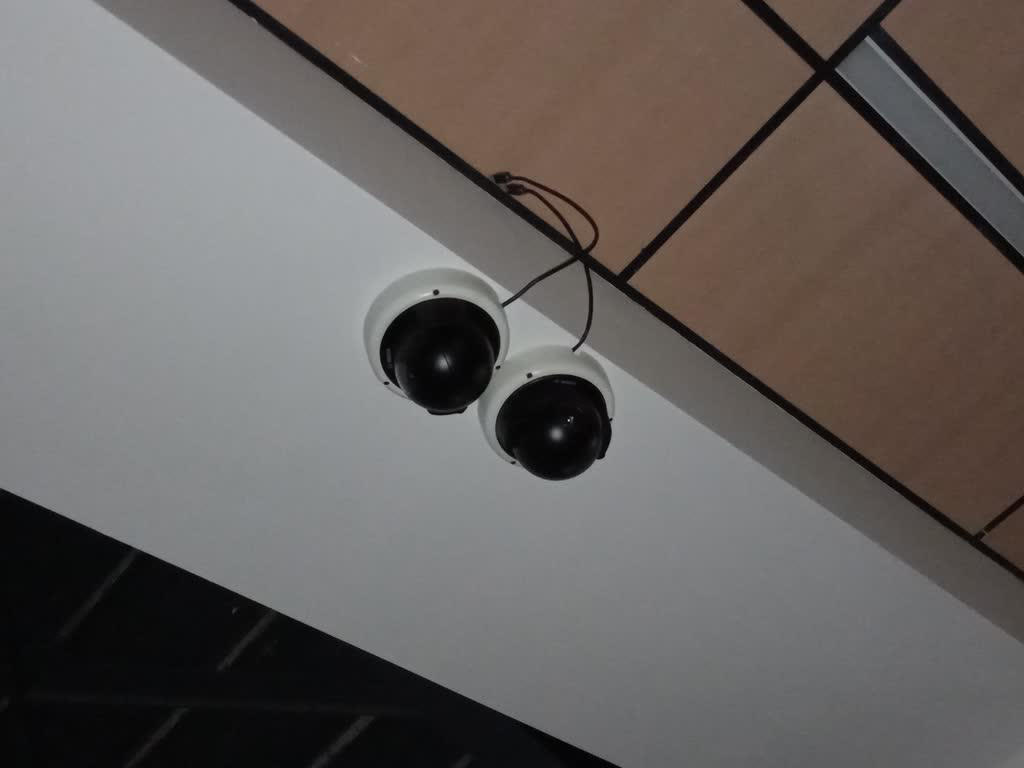

In [ ]:
from PIL import Image
Image.open('cv-ass2-semantic-seg-new/dataset2_processed/img/IMG20211203225252.jpg')

In [ ]:
from scipy.ndimage import label, generate_binary_structure

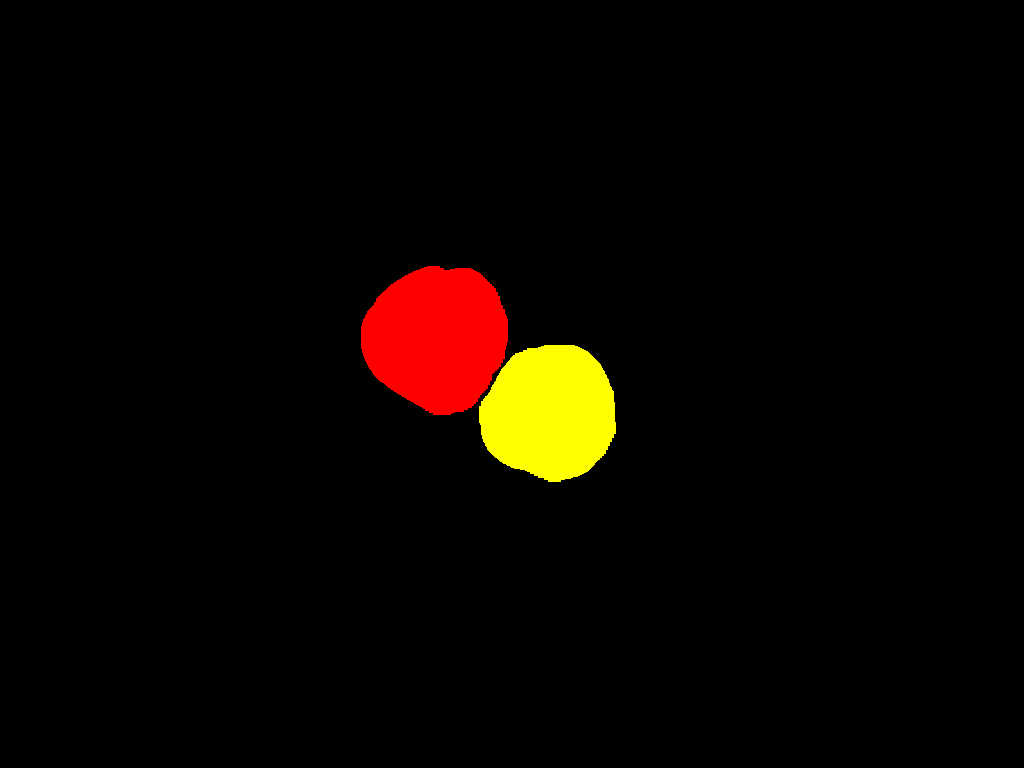

In [ ]:
mask = Image.open('cv-ass2-semantic-seg-new/dataset2_processed/masks_machine/IMG20211203225252.png').convert("L")
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
labeled_array, num_features = label(mask)
mask = Image.fromarray(labeled_array).convert("L")
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class CameraSmokeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = os.path.join(root, "dataset2_processed")
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "img"))))
        self.masks = list(sorted(os.listdir(os.path.join(self.root, "masks_machine"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks_machine", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert("L")

        mask = np.array(mask)
        # instances are encoded as different colors
        cls_ids = np.unique(mask)
        # first id is the background, so remove it
        cls_ids = cls_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == cls_ids[:, None, None]
        masks_ = []

        # get bounding box coordinates for each mask
        num_clss = len(cls_ids)
        boxes = []
        labels = []
        for i in range(num_clss):
            labeled_array, num_objs = label(masks[i])
            obj_ids = np.unique(labeled_array)[1:]
            obj_masks = labeled_array == obj_ids[:, None, None]
            
            for j in range(num_objs):
                pos = np.where(obj_masks[j])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                if xmin == xmax or ymin == ymax:
                    continue
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(cls_ids[i])
                masks_.append(obj_masks[j])
            

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
#         labels = torch.ones((num_objs,), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks_, dtype=torch.uint8)
        
        if len(boxes) == 0:
            print(img_path)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = CameraSmokeDataset('cv-ass2-semantic-seg-new/')

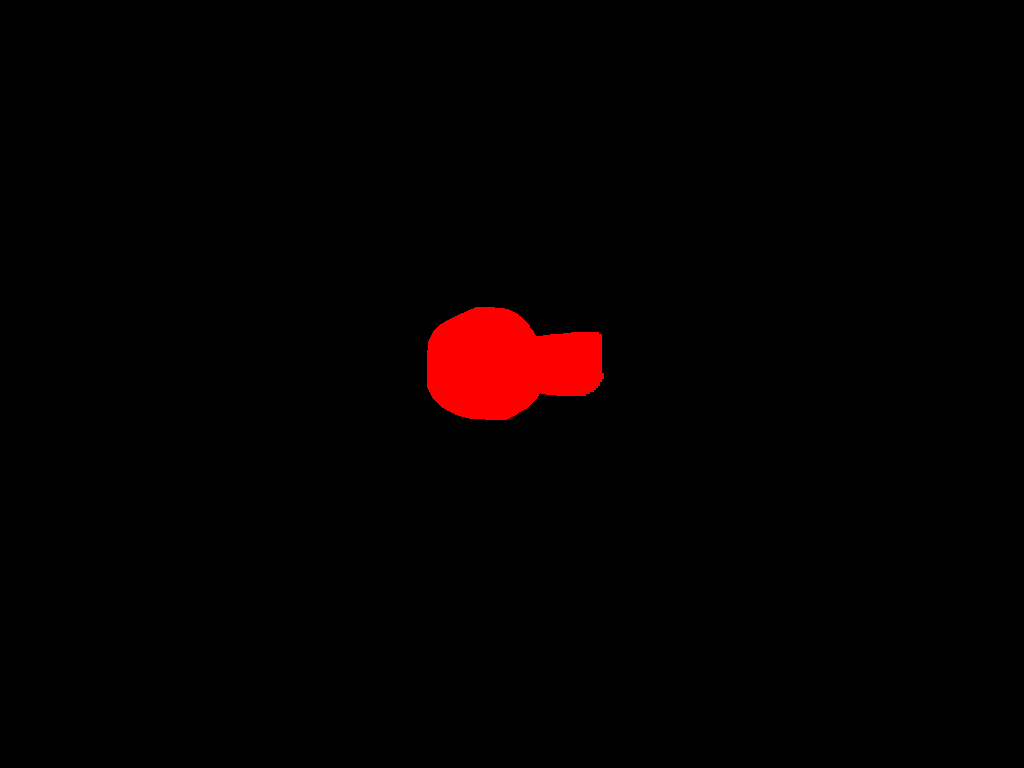

In [ ]:
a = Image.fromarray(dataset[i][1]["masks"].numpy()[0], mode='L')
a.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
a

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

### An Instance segmentation model for Cameras and Smoke detector Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
#%%shell

# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.8.2

%cp references/detection/utils.py ../
%cp references/detection/transforms.py ../
%cp references/detection/coco_eval.py ../
%cp references/detection/engine.py ../
%cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 60591, done.
remote: Counting objects: 100% (370/370), done.
remote: Compressing objects: 100% (365/365), done.
remote: Total 60591 (delta 323), reused 23 (delta 4), pack-reused 60221
Receiving objects: 100% (60591/60591), 112.56 MiB | 18.60 MiB/s, done.
Resolving deltas: 100% (49097/49097), done.
Checking out files: 100% (717/717), done.
/home/jupyter/work/resources/vision
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
%cd /home/jupyter/work/resources

/home/jupyter/work/resources


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = CameraSmokeDataset('cv-ass2-semantic-seg-new/', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /tmp/xdg_cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
/home/jupyter/.local/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = CameraSmokeDataset('cv-ass2-semantic-seg-new/', get_transform(train=True))
dataset_test = CameraSmokeDataset('cv-ass2-semantic-seg-new/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-18])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-18:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
#!g1.1
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /tmp/xdg_cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
#!g1.1
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  config.read(config_path)
/home/jupyter/.local/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/77]  eta: 0:03:15  lr: 0.000071  loss: 3.4692 (3.4692)  loss_classifier: 1.0915 (1.0915)  loss_box_reg: 0.0606 (0.0606)  loss_mask: 2.2584 (2.2584)  loss_objectness: 0.0525 (0.0525)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 2.5376  data: 2.3280  max mem: 2150
Epoch: [0]  [10/77]  eta: 0:01:06  lr: 0.000728  loss: 1.9028 (2.3176)  loss_classifier: 0.5107 (0.5810)  loss_box_reg: 0.1429 (0.1465)  loss_mask: 1.4500 (1.5534)  loss_objectness: 0.0257 (0.0308)  loss_rpn_box_reg: 0.0042 (0.0059)  time: 0.9958  data: 0.7813  max mem: 3113
Epoch: [0]  [20/77]  eta: 0:00:54  lr: 0.001385  loss: 1.0589 (1.8410)  loss_classifier: 0.1760 (0.3972)  loss_box_reg: 0.1430 (0.1608)  loss_mask: 0.4472 (0.9566)  loss_objectness: 0.0061 (0.2174)  loss_rpn_box_reg: 0.0026 (0.1089)  time: 0.8720  data: 0.6641  max mem: 3113
Epoch: [0]  [30/77]  eta: 0:00:42  lr: 0.002042  loss: 0.5232 (1.4515)  loss_classifier: 0.1123 (0.3009)  loss_box_reg: 0.1502 (0.1566)  loss_mask: 0.2233 (0.7068)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
#!g1.1
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
#!g1.1
prediction

[{'boxes': tensor([[ 402.2195,  329.8024,  601.8293,  594.6788],
          [ 277.4795, 1113.4537,  437.3643, 1185.2805],
          [ 283.1874, 1112.4077,  437.8452, 1184.9375]], device='cuda:0'),
  'labels': tensor([2, 2, 1], device='cuda:0'),
  'scores': tensor([0.9809, 0.3686, 0.0786], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

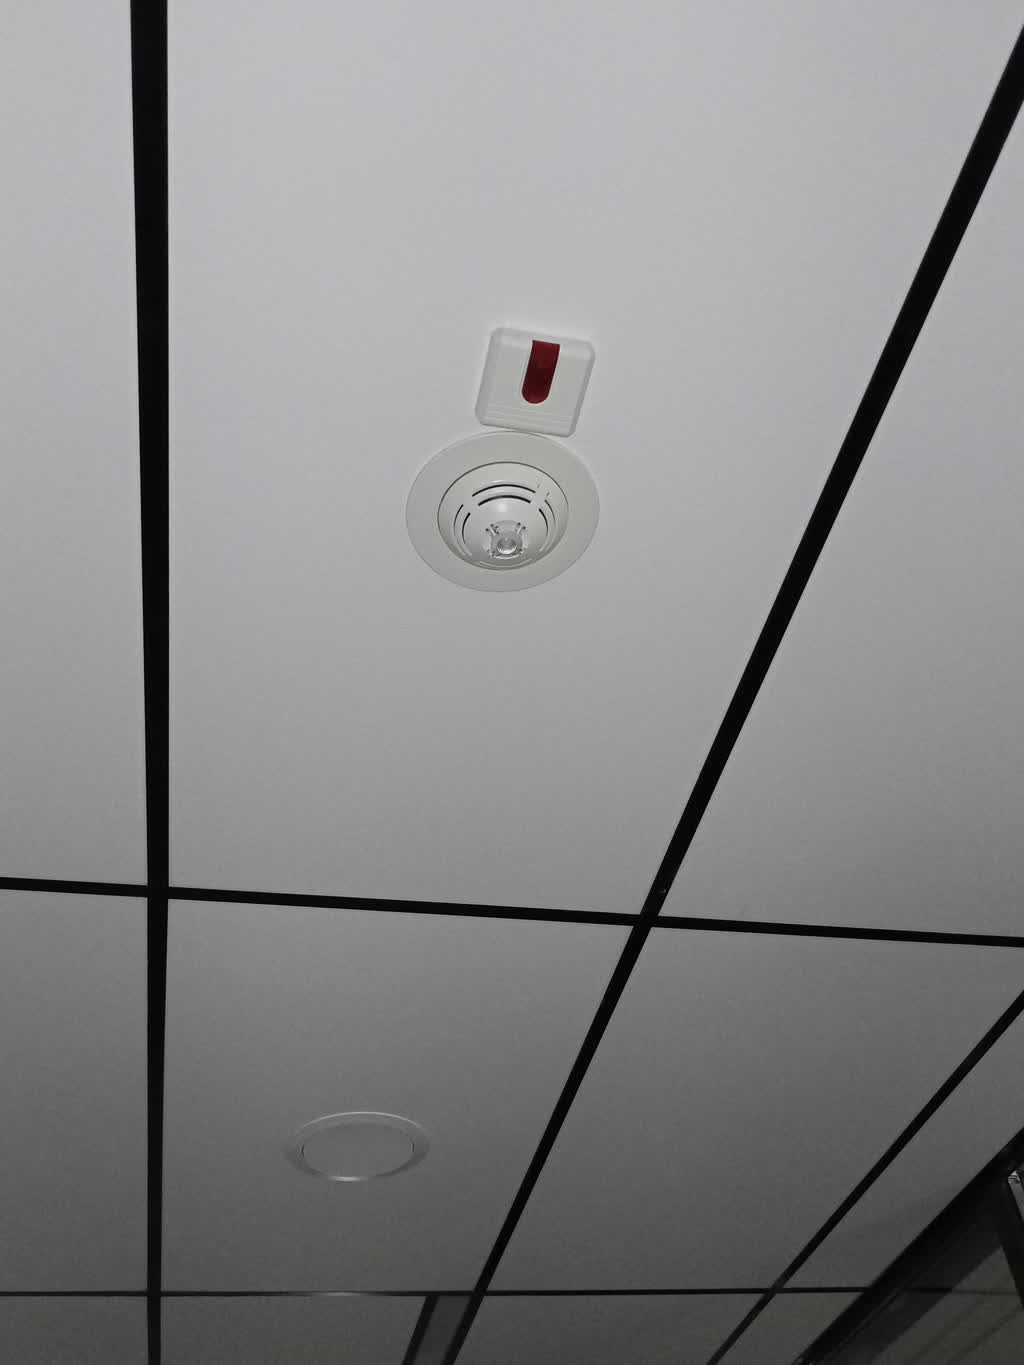

In [ ]:
#!g1.1
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

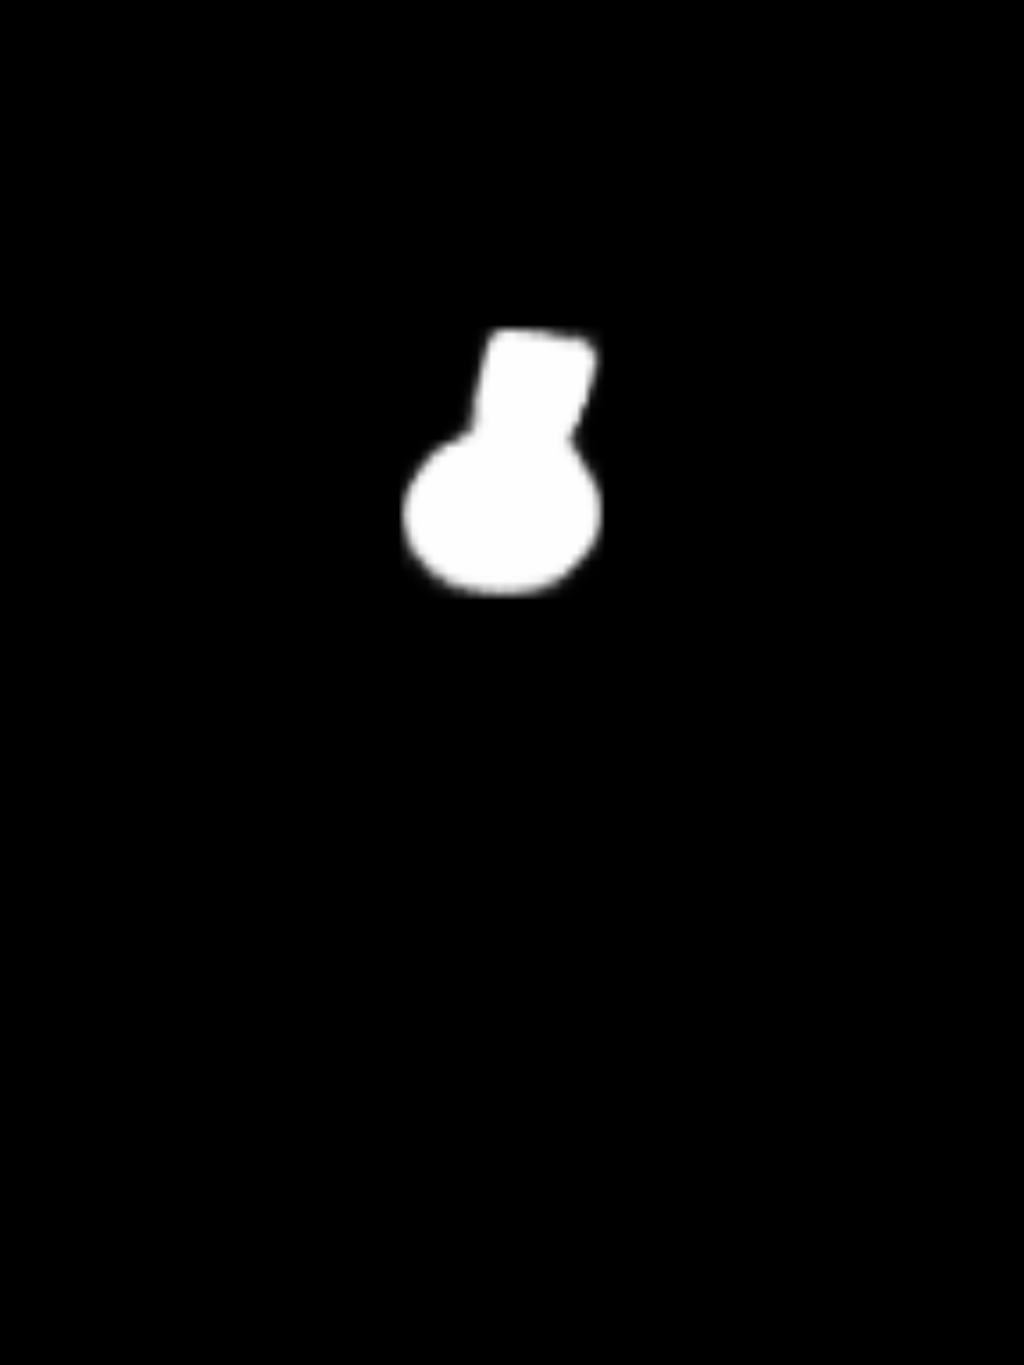

In [ ]:
#!g1.1
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks nice

## Performance

IoU metric: bbox
 * Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.847
 
 * Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 
 * Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.972
 
 
IoU metric: segm
 * Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.893
 
 * Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 
 * Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.972

In [ ]:
#!g1.1
# pick one image from the test set

def pred(i):
    img, _ = dataset_test[i]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        
    return Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
            

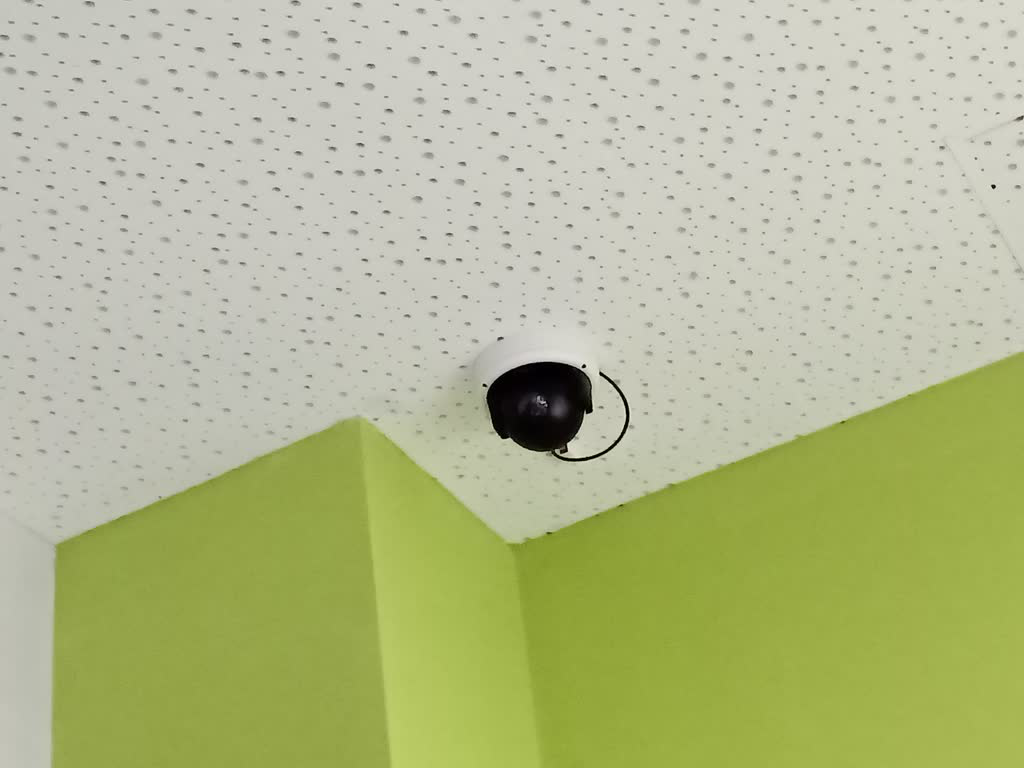

In [ ]:
#!g1.1
img1, mask1 = pred(1)
img1

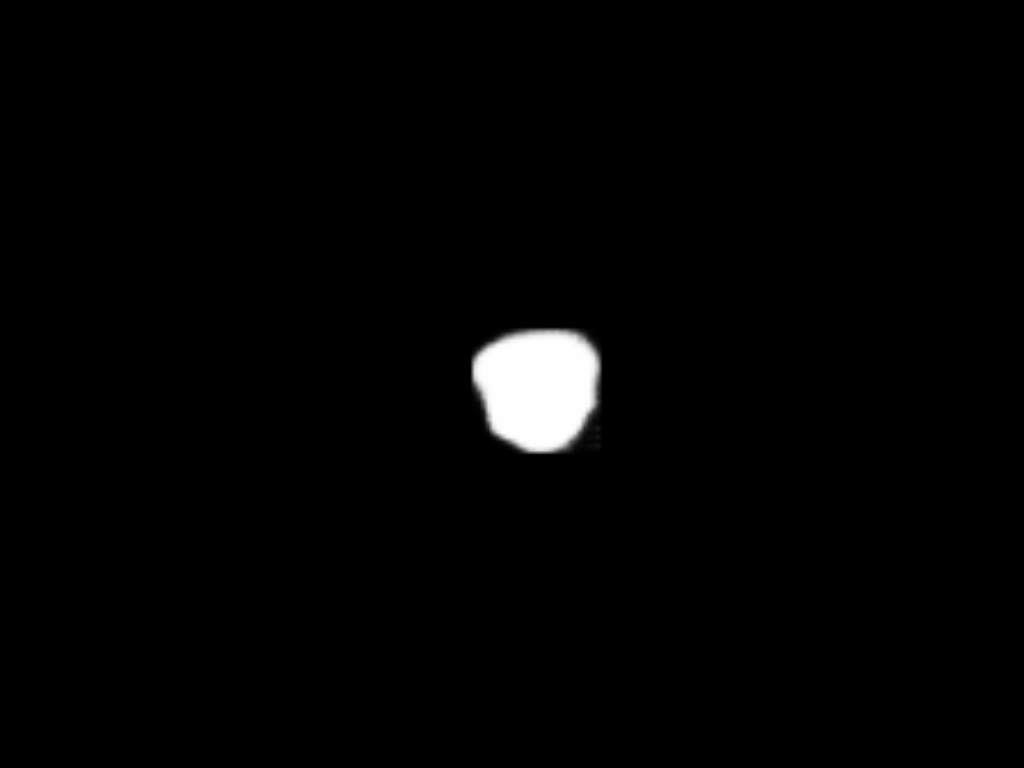

In [ ]:
#!g1.1
mask1